In [1]:
!pip install sagemaker

Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install sagemaker


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

import joblib
import warnings
warnings.filterwarnings('ignore')




In [2]:
import pandas as pd

#load dataset
data=pd.read_csv("creditcard.csv")

print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Data Exploration and Analysis
# Check for missing values3322
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Data Preprocessing
data['Time'] = pd.to_datetime(data['Time'])  # Convert 'Time' column to datetime datatype

# Define features (X) and target variable (y)
X = data.drop(['Class', 'Time'], axis=1)  # Features
y = data['Class']  # Target variable

# Remove constant features
data = data.loc[:, data.apply(pd.Series.nunique) != 1]


Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


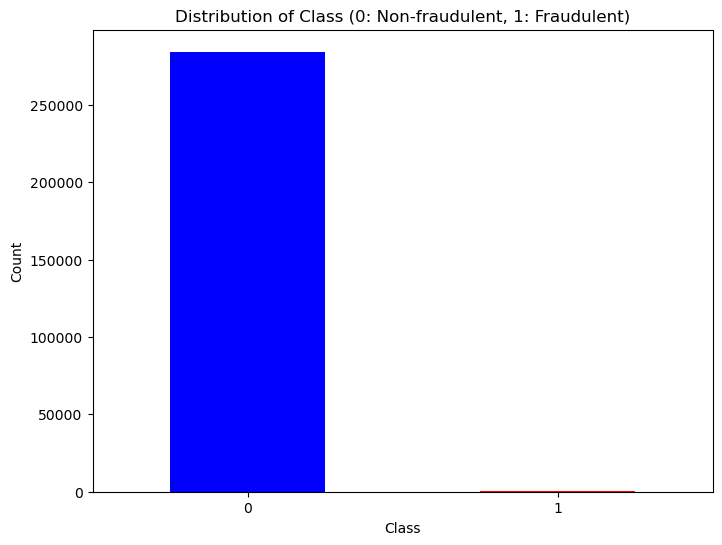

In [4]:
# Visualize the distribution of 'Class' (target variable)
plt.figure(figsize=(8, 6))
data['Class'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Class (0: Non-fraudulent, 1: Fraudulent)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [8]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the minority class
oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)


In [9]:
# Feature Engineering
# Add new features
data['Transaction_hour'] = pd.to_datetime(data['Time'], unit='s').dt.hour
data['Normalized_amount'] = (data['Amount'] - data['Amount'].mean()) / data['Amount'].std()




In [10]:
# Feature Selection
# Select features
selected_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
                    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
                    'Transaction_hour', 'Normalized_amount']



In [14]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Define features (X) and target variable (y)
X = data[selected_features]
y = data['Class']

# Perform PCA for dimensionality reduction
n_components = min(X.shape[0], X.shape[1])  # Number of components should be less than or equal to the minimum of samples or features
pca = PCA(n_components=n_components)  
X_pca = pca.fit_transform(X)

# Perform feature selection on the PCA-transformed data
k_best_selector = SelectKBest(score_func=f_classif, k=5)  # Adjust k as needed
X_k_best = k_best_selector.fit_transform(X_pca, y)

# Get the indices of selected features
selected_indices = k_best_selector.get_support(indices=True)

# Map selected PCA components back to original feature names
selected_features = [selected_features[i] for i in selected_indices]

print("Selected features using ANOVA F-test after PCA:")
print(selected_features)


Selected features using ANOVA F-test after PCA:
['V3', 'V6', 'V7', 'V9', 'V10']


In [17]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:

# Model Selection and Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model on the training data
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", np.mean(cv_scores))



In [ ]:
# Evaluate model performance using accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)


In [ ]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)



In [ ]:
# Model Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)



In [ ]:


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Training
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", np.mean(cv_scores))



In [ ]:

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [1, 5, 10],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)



In [ ]:

# Model Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)



In [ ]:

# Additional Visualizations
# Creating a heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
plt.figure(figsize=(15,2))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual VS. Predicted')